In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [117]:
import os
import PIL
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class FoodData(Dataset):
    def __init__(self):
        self.selected_dataset_dir = os.getcwd()

        df = pd.read_csv('train.csv' ,header=0, index_col=0)
        self.all_filenames = list(df['path_img'])
        self.all_labels = df.set_index('path_img')
        self.num_classes = df['label'].max(0) + 1
    

    def __len__(self):
        return len(self.all_filenames)
        

    def __getitem__(self, idx):
        selected_filename = self.all_filenames[idx]
        
        imagepil = PIL.Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB').resize((252, 252), resample=Image.LANCZOS)

        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        image = transform(imagepil)
        
        #load label
        label = torch.nn.functional.one_hot(torch.tensor(self.all_labels.loc[selected_filename]), self.num_classes)
        #label = torch.tensor(self.all_labels.loc[selected_filename])

        
        sample = {'data':image, #image, for input into NN
                  'label':label}
        return image, label

In [51]:
torch.nn.functional.one_hot(torch.tensor(6), 8)

tensor([0, 0, 0, 0, 0, 0, 1, 0])

In [118]:
batch_size = 8

trainset = FoodData()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = FoodData()
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('burger', 'chicken', 'doughnut', 'chips',
           'hot dog', 'pizza', 'sandwich', 'potato')

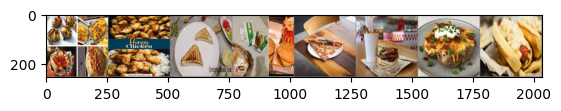

potato chicken sandwich burger pizza burger potato hot dog


In [119]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

In [98]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 248
        self.pool = nn.MaxPool2d(2, 2) # 124
        self.conv2 = nn.Conv2d(6, 16, 5) # 120
        self.fc1 = nn.Linear(16 * 60* 60, 220)
        self.fc2 = nn.Linear(220, 104)
        self.fc3 = nn.Linear(104, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=104, bias=True)
  (fc3): Linear(in_features=104, out_features=8, bias=True)
)

In [ ]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# load
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

In [99]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [100]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).float().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,    21] loss: 0.021
[1,    41] loss: 0.021
[1,    61] loss: 0.021
[1,    81] loss: 0.021
[1,   101] loss: 0.021
[1,   121] loss: 0.021
[1,   141] loss: 0.021
[1,   161] loss: 0.021
[1,   181] loss: 0.021
[1,   201] loss: 0.021
[1,   221] loss: 0.020
[1,   241] loss: 0.020
[1,   261] loss: 0.020
[1,   281] loss: 0.020
[1,   301] loss: 0.020
[1,   321] loss: 0.020
[1,   341] loss: 0.020
[1,   361] loss: 0.020
[1,   381] loss: 0.020


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,   401] loss: 0.019
[1,   421] loss: 0.020
[1,   441] loss: 0.020
[1,   461] loss: 0.020
[1,   481] loss: 0.020
[1,   501] loss: 0.020
[1,   521] loss: 0.019
[1,   541] loss: 0.020
[1,   561] loss: 0.019
[1,   581] loss: 0.019
[1,   601] loss: 0.019
[1,   621] loss: 0.019
[1,   641] loss: 0.019
[1,   661] loss: 0.019
[1,   681] loss: 0.019
[1,   701] loss: 0.019
[1,   721] loss: 0.019
[1,   741] loss: 0.019
[1,   761] loss: 0.018
[1,   781] loss: 0.018
[1,   801] loss: 0.019
[1,   821] loss: 0.019
[1,   841] loss: 0.019
[1,   861] loss: 0.019
[1,   881] loss: 0.019
[1,   901] loss: 0.019
[1,   921] loss: 0.019
[1,   941] loss: 0.019
[1,   961] loss: 0.019
[1,   981] loss: 0.018
[1,  1001] loss: 0.018
[1,  1021] loss: 0.017
[1,  1041] loss: 0.019
[1,  1061] loss: 0.018
[1,  1081] loss: 0.018
[1,  1101] loss: 0.017
[1,  1121] loss: 0.019
[1,  1141] loss: 0.019
[1,  1161] loss: 0.017
[1,  1181] loss: 0.018
[1,  1201] loss: 0.019
[1,  1221] loss: 0.017
[1,  1241] loss: 0.017
[1,  1261] 

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2,    81] loss: 0.018
[2,   101] loss: 0.018
[2,   121] loss: 0.017
[2,   141] loss: 0.018
[2,   161] loss: 0.016
[2,   181] loss: 0.018
[2,   201] loss: 0.017
[2,   221] loss: 0.017
[2,   241] loss: 0.017
[2,   261] loss: 0.017
[2,   281] loss: 0.017
[2,   301] loss: 0.017
[2,   321] loss: 0.018
[2,   341] loss: 0.018
[2,   361] loss: 0.017
[2,   381] loss: 0.017
[2,   401] loss: 0.017
[2,   421] loss: 0.018
[2,   441] loss: 0.017
[2,   461] loss: 0.018
[2,   481] loss: 0.017
[2,   501] loss: 0.017
[2,   521] loss: 0.016
[2,   541] loss: 0.017
[2,   561] loss: 0.017
[2,   581] loss: 0.016
[2,   601] loss: 0.016
[2,   621] loss: 0.018
[2,   641] loss: 0.017
[2,   661] loss: 0.016
[2,   681] loss: 0.016
[2,   701] loss: 0.018
[2,   721] loss: 0.016
[2,   741] loss: 0.017
[2,   761] loss: 0.017
[2,   781] loss: 0.017
[2,   801] loss: 0.016
[2,   821] loss: 0.017
[2,   841] loss: 0.017
[2,   861] loss: 0.017
[2,   881] loss: 0.016
[2,   901] loss: 0.015
[2,   921] loss: 0.017
[2,   941] 

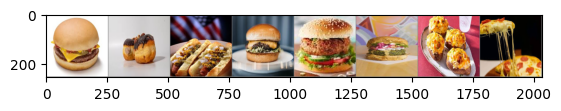

GroundTruth:  burger doughnut hot dog burger burger burger potato pizza


In [102]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

In [106]:
outputs = net(images.to(device))

In [108]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  burger potato sandwich burger burger sandwich potato burger


In [115]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == torch.argmax(labels)).sum().item()
print(correct, total)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1404 11189
Accuracy of the network on the 10000 test images: 12 %


In [116]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            label = torch.argmax(label)
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy for class: burger is 49.4 %
Accuracy for class: chicken is 0.0 %
Accuracy for class: doughnut is 0.0 %
Accuracy for class: chips is 0.0 %
Accuracy for class: hot dog is 0.0 %
Accuracy for class: pizza is 0.0 %
Accuracy for class: sandwich is 25.4 %
Accuracy for class: potato is 24.3 %
